<a href="https://colab.research.google.com/github/liuqidev/data-mining-in-action/blob/master/%E4%BA%A4%E9%80%9A%E5%A4%A7%E6%95%B0%E6%8D%AE%E2%80%94%E2%80%94%E5%87%BA%E8%A1%8C%E9%9C%80%E6%B1%82%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 出行需求预测

## 实验需求说明

时间为从2×年×月1日至×年×月21日。网约车需求数据的时间间隔为10分钟，每天144个采样点，共计3024个点。网约车需求数据每一行代表一个时间点，而每一列代表一个区域。数据中各个区域已经划分完成，共计66个区域。使用一部分数据作为训练集，一部分数据作为测试集，建立预测模型，测试预测效果。请基于这个数据，完成如下几个问题。
- （1）如何划分测试集或训练集，是否采用交叉验证方法？
- （2）如何提取用于预测的特征变量？
- （3）采用哪一种模型作为网约车需求预测的模型？
- （4）采用哪一种评价指标评价预测效果？
- 在完成数值实验后，请撰写一份5页以内的网约车需求预测报告，描述方法和数值实验结果。


## 统计规律探究

In [0]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.axisbelow'] = True
from matplotlib import cm
import seaborn as sns
from scipy.io import loadmat


In [0]:
mat = loadmat('data.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'demand'])


In [0]:
demand_data=mat['demand']
print(type(demand_data))

<class 'numpy.ndarray'>


In [0]:
demand_data.shape

(3024, 66)

总共是3024个时间片，

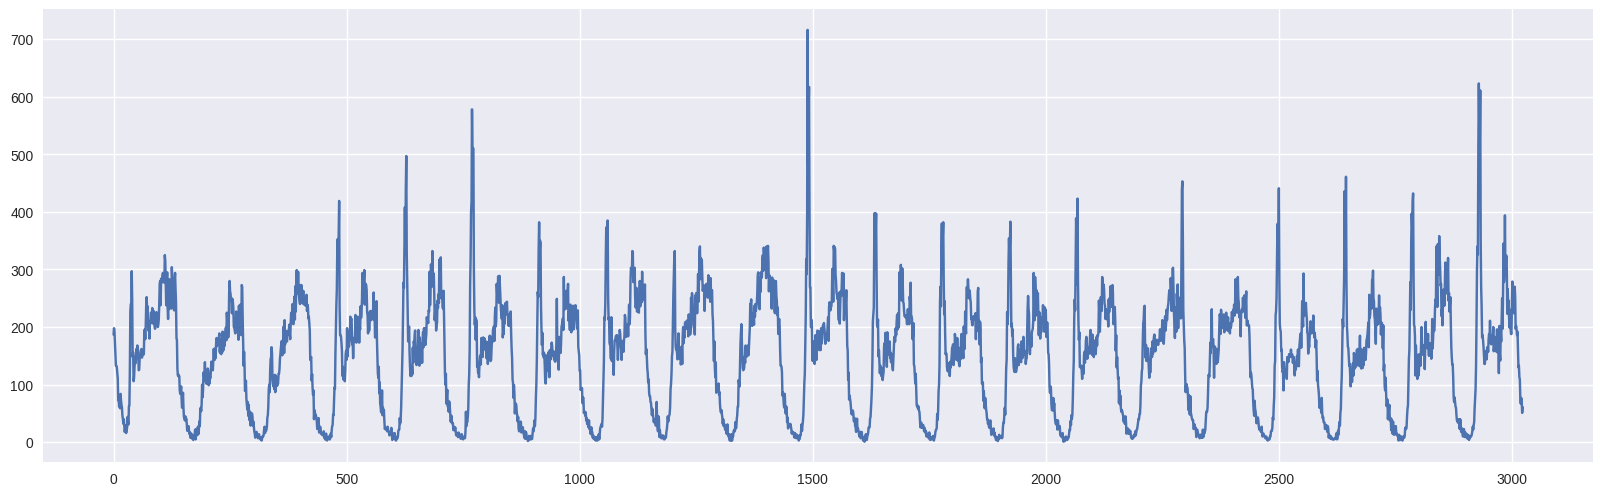

In [0]:
fig=plt.figure(figsize=(20, 6))
ax=fig.add_subplot(111)
ax.plot(demand_data[:, 0])
plt.show()

每一天是144个时间片，每个时间片是10分钟

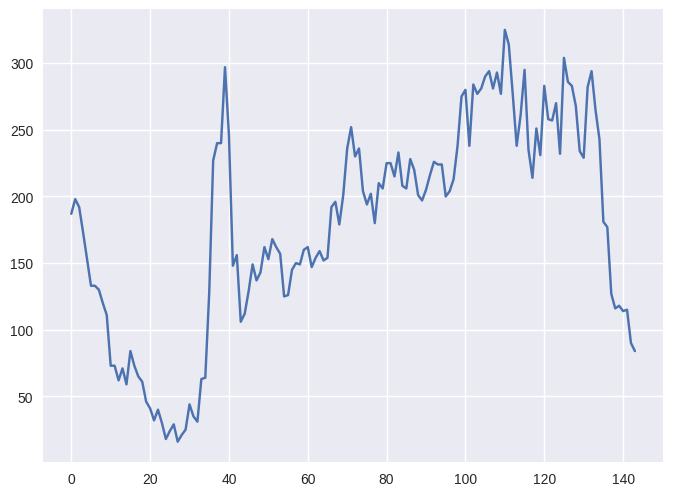

In [0]:
fig1=plt.figure(figsize=(8, 6))
ax1=fig1.add_subplot(111)
ax1.plot(demand_data[:144, 0])
plt.show()

In [0]:
num_sample=demand_data.shape[0]
num_area=demand_data.shape[1]
# num_per_day=144
num_time_gap=10
num_one_day_h=24
num_one_h_m=60
num_per_day=math.ceil(num_one_day_h*num_one_h_m/num_time_gap) # 24(h)*60(min)/10(/min)=144
num_day= math.floor(num_sample/num_per_day)

print('Num of samples: {0}'.format(num_sample))
print('Num of samples per day: {0}'.format(num_per_day))
print('Num of areas: {0}'.format(num_area))
print('Num of days: {0}'.format(num_day))


Num of samples: 3024
Num of samples per day: 144
Num of areas: 66
Num of days: 21


In [0]:
# np.sum(demand_data[144:144*2, 0])

In [0]:
# area0_days = [demand_data[i*num_per_day:(i+1)*num_per_day, 0] for i in range(num_day)]
# print(area0_days)

demand_merged=[]
num_merge_samples=144 # which means every 144 samples, merge them to one sample(one sample a day)
# num_merge=math.ceil(num_sample/num_merge_samples) 
num_merge=math.floor(num_sample/num_merge_samples) 

for idx in range(num_area):
  one_area_days_demand=[]
  j =0
  while j < num_merge:
    if (j+1)*num_merge_samples > num_sample:
      merge_samples=demand_data[j*num_merge_samples:, idx]
    else:
      merge_samples=demand_data[j*num_merge_samples:(j+1)*num_merge_samples, idx]
    slide_sum=np.sum(merge_samples)
    #print(slide_sum)
    one_area_days_demand.append(slide_sum)
    j=j+1
#   print(one_area_days_demand)
  demand_merged.append(one_area_days_demand)
    
# print(np.array(demand_merged))
print(np.array(demand_merged).shape)

(66, 21)


In [0]:
def merge_by_time(demand_data, num_merge_samples=144, is_transpose=False):
  import numpy as np
  demand_merged=[]
  #num_merge_samples=144
  num_merge=math.floor(num_sample/num_merge_samples) 

  for idx in range(num_area):
    one_area_days_demand=[]
    j =0
    while j < num_merge:
      if (j+1)*num_merge_samples > num_sample:
        merge_samples=demand_data[j*num_merge_samples:, idx]
      else:
        merge_samples=demand_data[j*num_merge_samples:(j+1)*num_merge_samples, idx]
      slide_sum=np.sum(merge_samples)
      #print(slide_sum)
      one_area_days_demand.append(slide_sum)
      j=j+1
    #print(one_area_days_demand)
    demand_merged.append(one_area_days_demand)

  # print(np.array(demand_merged))
  # print(np.array(demand_merged).shape)
  demand_merged=np.array(demand_merged)
  if is_transpose:
    return demand_merged
  else:
    return demand_merged.T

In [0]:
num_merge_samples=144
demand_merged=merge_by_time(demand_data, num_merge_samples, True)
print('Merged every {} samples data of {} areas'.format(num_merge_samples, demand_merged.shape[1]))
print('Shape of merged data: {0}'.format(demand_merged.shape))

Merged every 144 samples data of 21 areas
Shape of merged data: (66, 21)


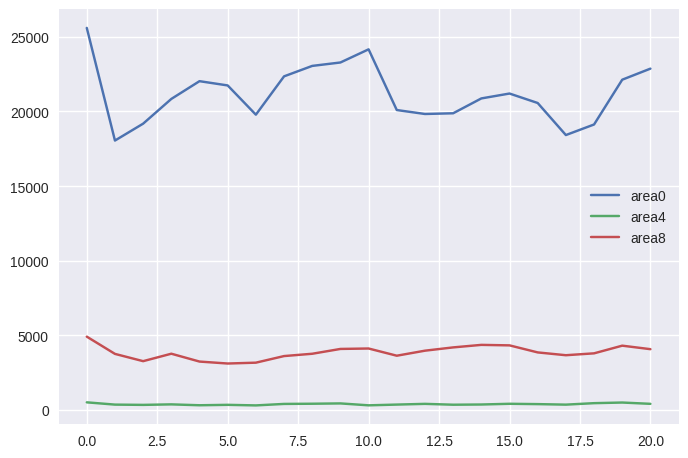

In [0]:
plt.plot(demand_merged[0], label='area0')
plt.plot(demand_merged[4], label='area4')
plt.plot(demand_merged[8], label='area8')
plt.legend(loc='best')
plt.show()

In [0]:
num_merge_samples=2
demand_merged=merge_by_time(demand_data, num_merge_samples, False)
print('Merged every {} samples data of {} areas'.format(num_merge_samples, demand_merged.shape[1]))
print('Shape of merged data: {0}'.format(demand_merged.shape))

Merged every 2 samples data of 66 areas
Shape of merged data: (1512, 66)


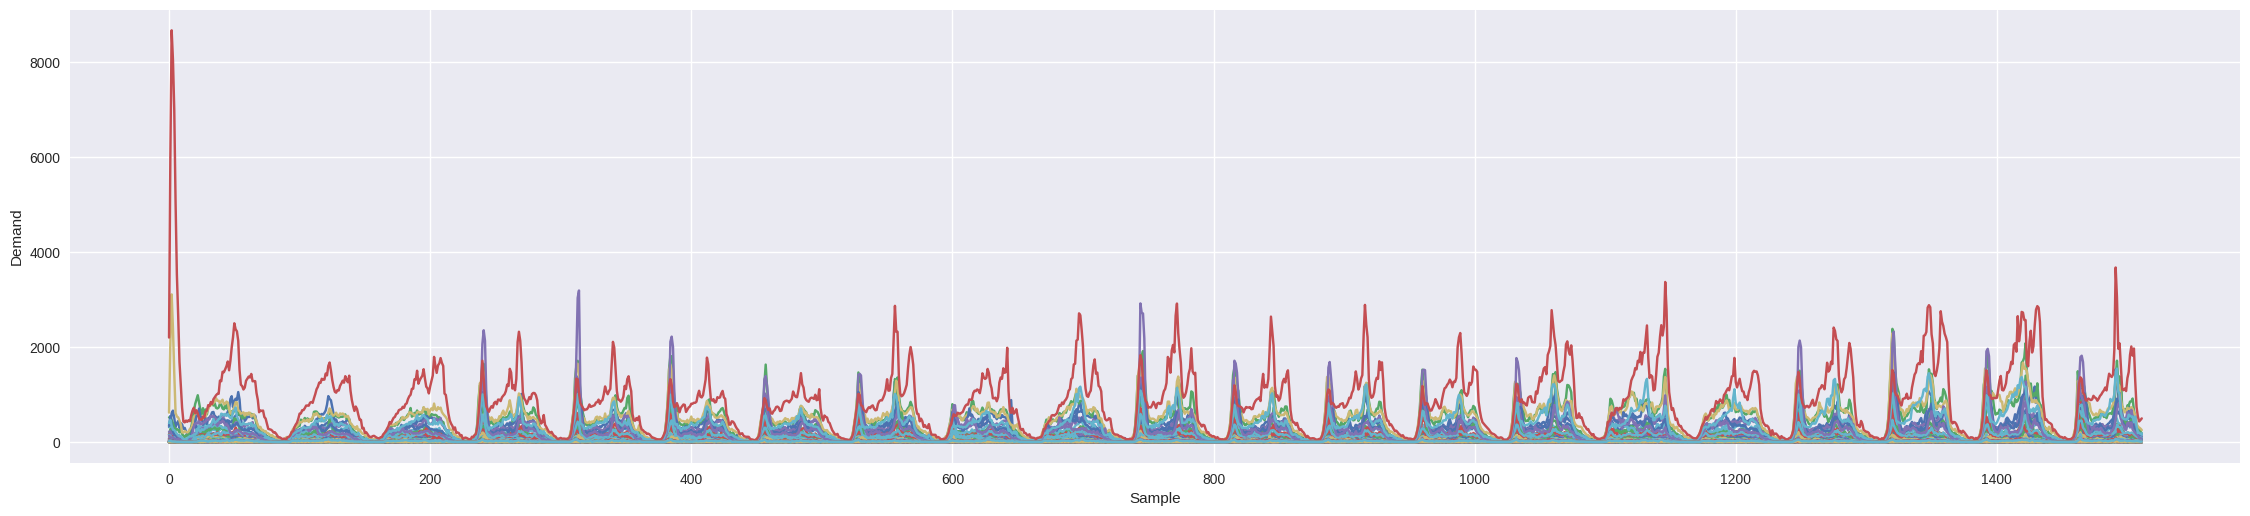

In [0]:
fig=plt.figure(figsize=(28, 6))
ax=plt.gca()
# ax.plot(demand_merged[:,0], label='area0')
# ax.plot(demand_merged[:,4], label='area4')
# ax.plot(demand_merged[:,8], label='area8')
for i_area in range(num_area):
  ax.plot(demand_merged[:,i_area], label='area_{0}'.format(i_area))
# ax.legend(loc=1)
ax.set_xlabel('Sample')
ax.set_ylabel('Demand')
plt.show()

Merged every 144 samples data of 66 areas
Shape of merged data: (21, 66)


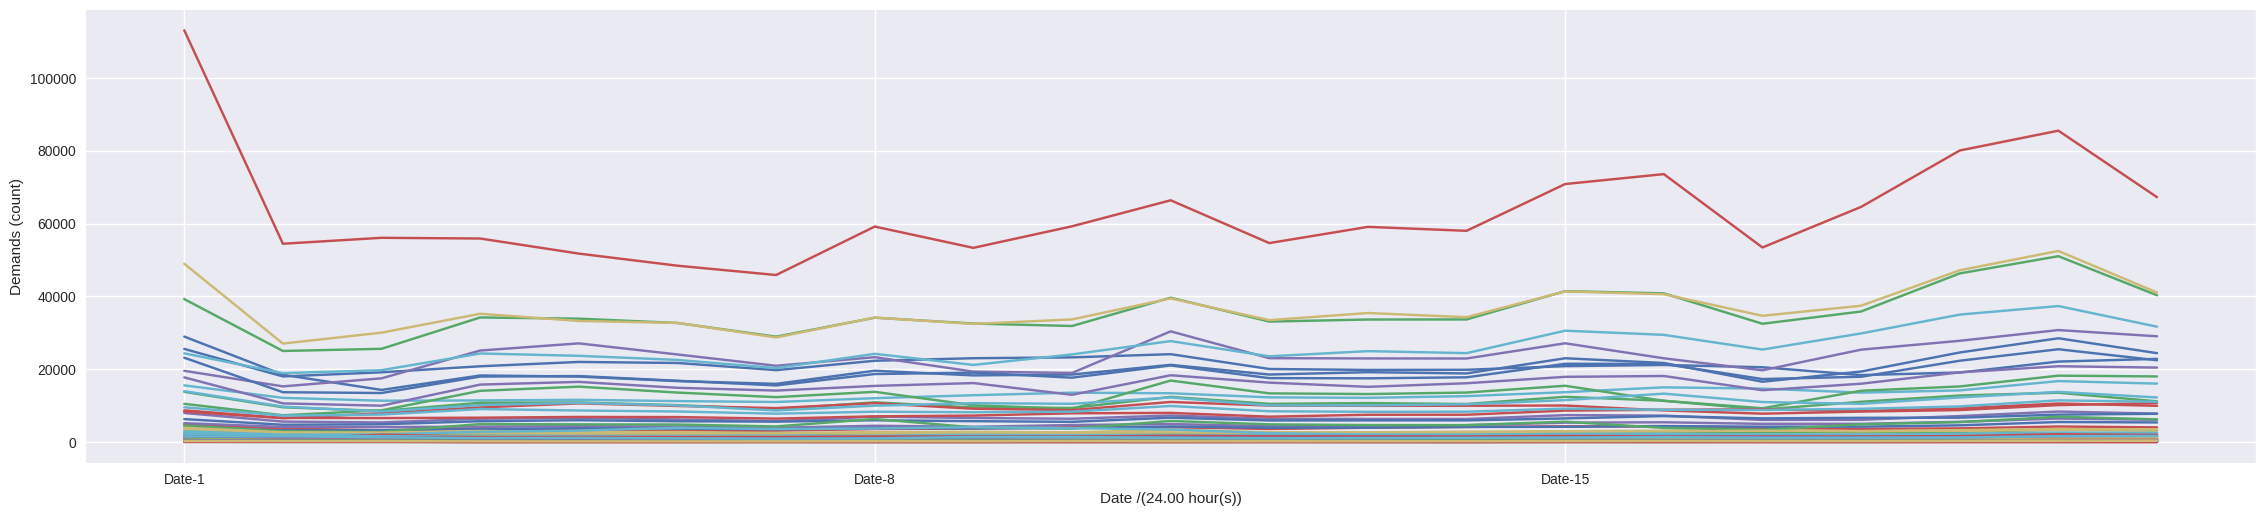

In [0]:
num_merge_samples=144
demand_merged=merge_by_time(demand_data, num_merge_samples, False)
print('Merged every {} samples data of {} areas'.format(num_merge_samples, demand_merged.shape[1]))
print('Shape of merged data: {0}'.format(demand_merged.shape))

xtickarange=np.arange(0,demand_merged.shape[0]+1, 7)


fig=plt.figure(figsize=(28, 6))
ax=plt.gca()
for i_area in range(num_area):
  #ax.plot(np.log(demand_merged[:,i_area]), label='area_{0}'.format(i_area))
  ax.plot(demand_merged[:,i_area], label='area_{0}'.format(i_area))
# ax.legend(loc=1)
ax.set_xticks(xtickarange)
ax.set_xticklabels(['Date-'+str(t+1) for t in range(0, demand_merged.shape[0], 7)])
ax.set_xlabel('Date /({0:.2f} hour(s))'.format(num_merge_samples*10/60))
ax.set_ylabel('Demands (count)')
plt.show()

将不同的采样点的需求进行合并，可以观察一段时间内需求的变化和分布。从上面简单的输出可以看到，不同区域之间的出量差异显著。同一区域在不同时间段的出行量也是变化很大。总的来说，两个最最关键的因素，一个时间，另一个是区域。

In [0]:
# xtickarange=np.arange(0,demand_merged.shape[0], 1)
# xticklabels=['Date-'+str(t+1) for t in range(demand_merged.shape[0])]

# ytickarange=np.arange(0,demand_merged.shape[1], 1)
# yticklabels=['Area-'+str(t+1) for t in range(demand_merged.shape[1])]

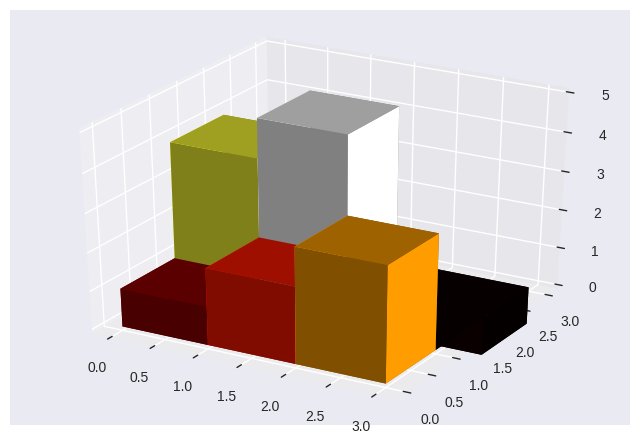

In [0]:
a=np.arange(3)
b=np.arange(3)
x_, y_ = np.meshgrid(a, b)

x=x_.ravel()
y=y_.ravel()

z = np.zeros(len(x_.ravel()))


dx = np.ones(len(y))
dy = np.ones(len(y))
dz=[]

mv=np.array([[1, 2, 3], [4, 5, 0], [1, 0, -1]])
dz=mv.ravel()
    
    
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
# ax.bar3d(x, y, z, dx, dy, dz, shade=True, cmap='jet')

colors=plt.cm.hot(mv.flatten()/float(mv.max()))
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=colors)
plt.show()



In [0]:
# %matplotlib inline

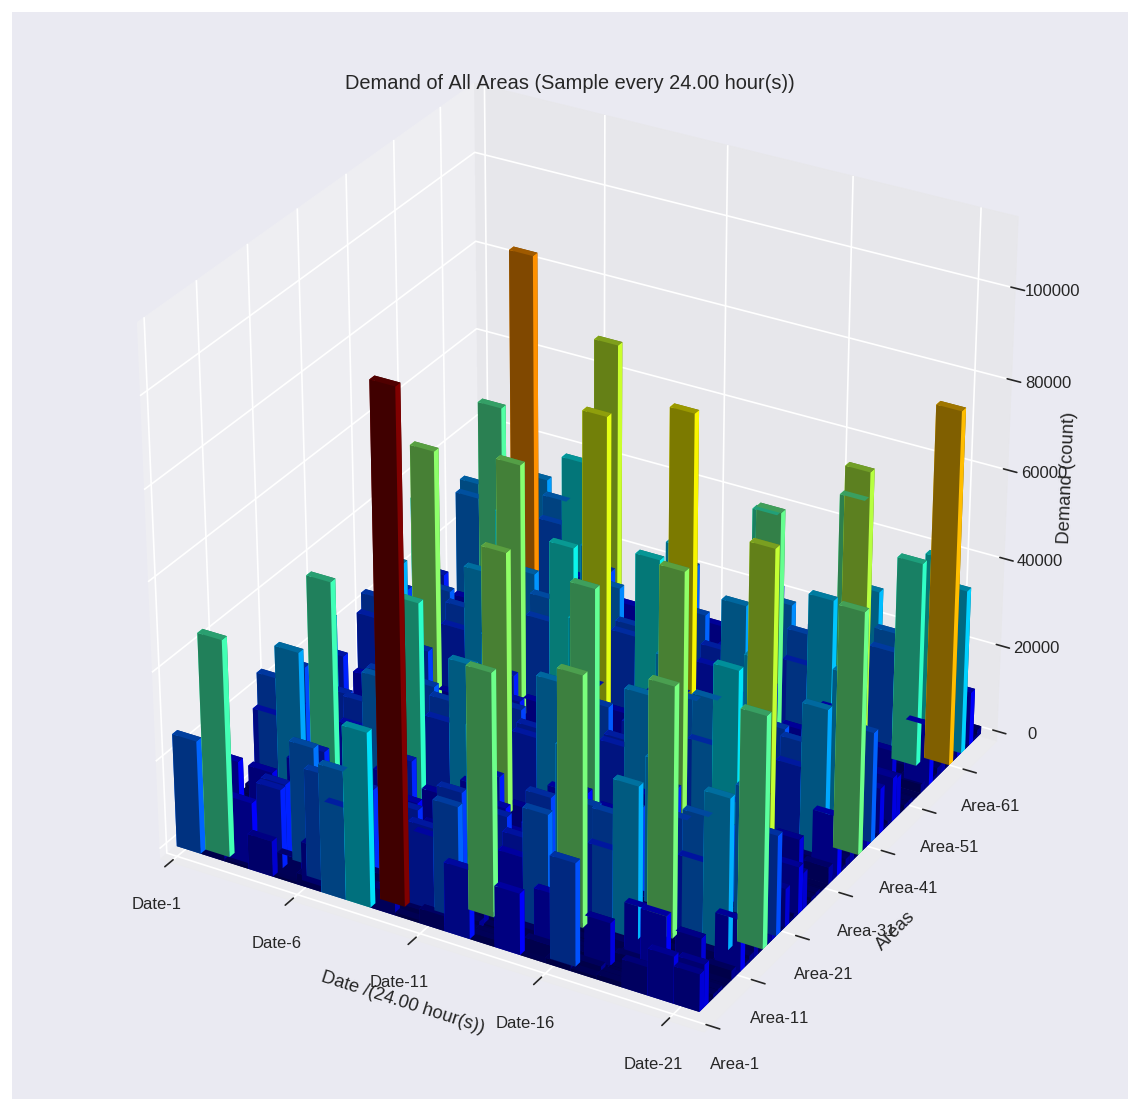

In [0]:

a=np.arange(demand_merged.shape[0])
b=np.arange(demand_merged.shape[1])
x_, y_ = np.meshgrid(a, b)

x=x_.ravel()
y=y_.ravel()

z = np.zeros(len(x_.ravel()))


fig=plt.figure(figsize=(12, 12), dpi=120)
ax=fig.add_subplot(111, projection='3d')

dx = np.ones(len(y))
dy = np.ones(len(y))
dz = demand_merged.ravel()


# ax.bar3d(x, y, z, dx, dy, dz, shade=True, cmap='jet')

colors=plt.cm.jet(demand_merged.ravel()/float(demand_merged.max()))
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color=colors)

xtickarange=np.arange(0,demand_merged.shape[0], 5)
xticklabels=['Date-'+str(t+1) for t in range(0, demand_merged.shape[0], 5)]

ytickarange=np.arange(0,demand_merged.shape[1], 10)
yticklabels=['Area-'+str(t+1) for t in range(0, demand_merged.shape[1], 10)]

ax.set_xlim(0, demand_merged.shape[0])
ax.set_ylim(0, demand_merged.shape[1])

ax.set_xticks(xtickarange)
ax.set_xticklabels(xticklabels)
ax.set_yticks(ytickarange)
ax.set_yticklabels(yticklabels)


ax.set_xlabel('Date /({0:.2f} hour(s))'.format(num_merge_samples*10/60))
ax.set_ylabel('Areas')
ax.set_zlabel('Demand (count)')

ax.set_title('Demand of All Areas (Sample every {0:.2f} hour(s))'.format(num_merge_samples*10/60))

plt.savefig('Demand_of_All_Areas_(Sample_every_{0:.2f}_hour(s)).png'.format(num_merge_samples*10/60))
plt.savefig('Demand_of_All_Areas_(Sample_every_{0:.2f}_hour(s)).pdf'.format(num_merge_samples*10/60))
plt.show()



Merged every 6 samples data of 66 areas
Shape of merged data: (504, 66)


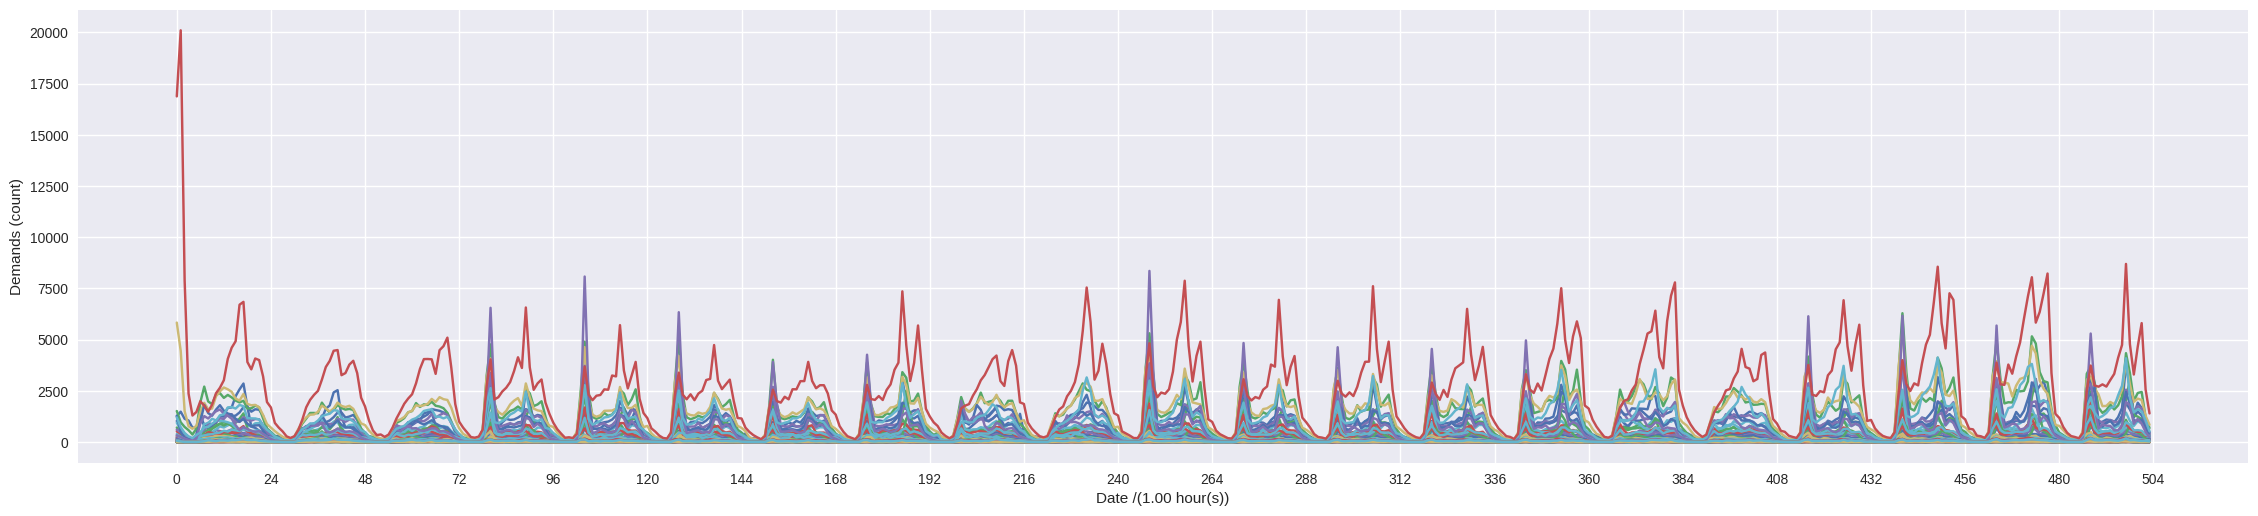

In [0]:
num_merge_samples=6 # 144-24h 6-1h
demand_merged=merge_by_time(demand_data, num_merge_samples, False)
print('Merged every {} samples data of {} areas'.format(num_merge_samples, demand_merged.shape[1]))
print('Shape of merged data: {0}'.format(demand_merged.shape))

xtickarange=np.arange(0,demand_merged.shape[0]+1, 24)


fig=plt.figure(figsize=(28, 6))
ax=plt.gca()
for i_area in range(num_area):
  #ax.plot(np.log(demand_merged[:,i_area]), label='area_{0}'.format(i_area))
  ax.plot(demand_merged[:,i_area], label='area_{0}'.format(i_area))
# ax.legend(loc=1)
ax.set_xticks(xtickarange)
# ax.set_xticklabels(['Date-'+str(t+1) for t in range(0, demand_merged.shape[0], 7)])
ax.set_xlabel('Date /({0:.2f} hour(s))'.format(num_merge_samples*10/60))
ax.set_ylabel('Demands (count)')
plt.show()

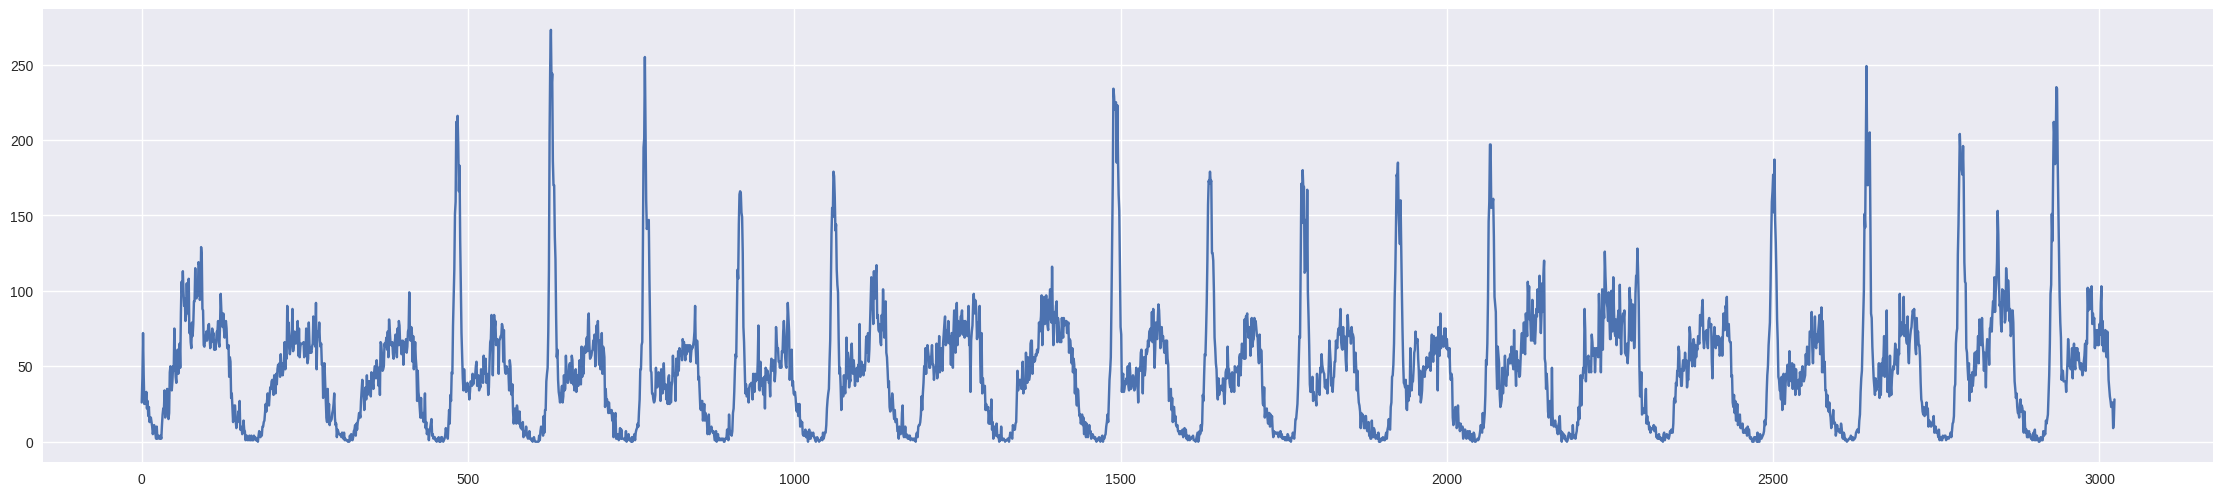

In [0]:
fig=plt.figure(figsize=(28, 6))
plt.plot(demand_data[:,3])
plt.show()

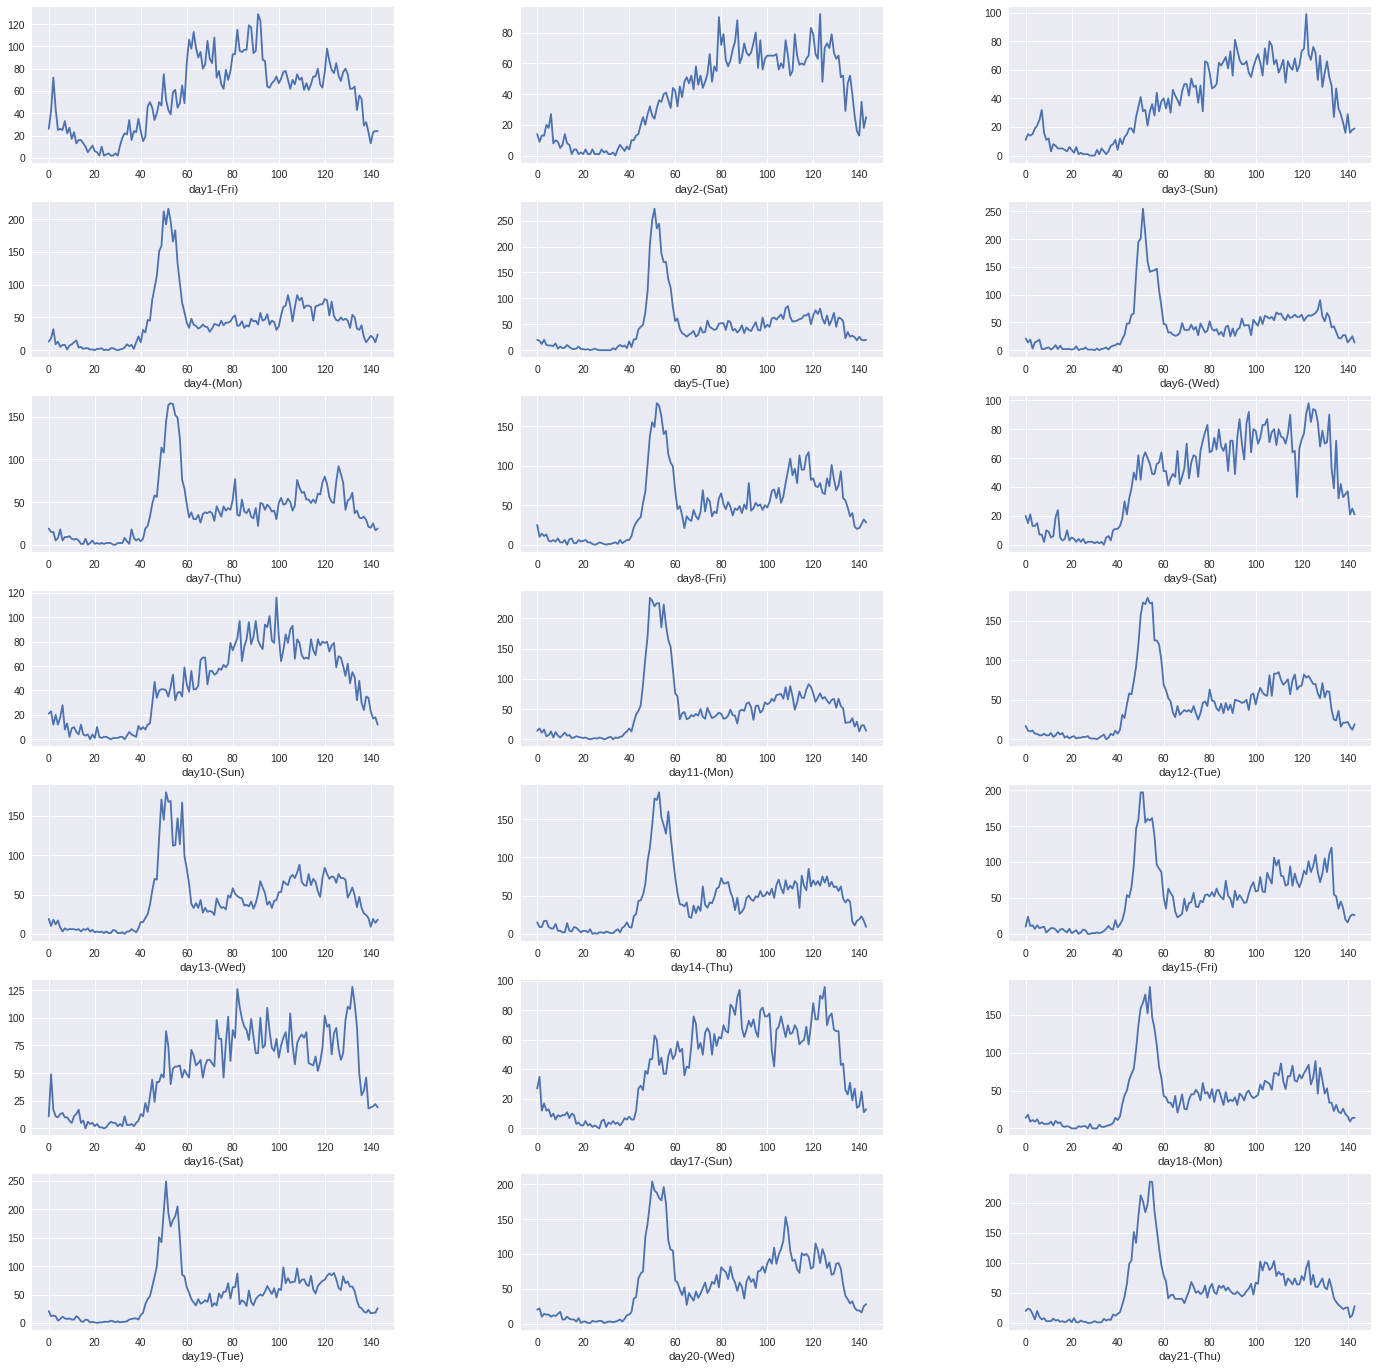

In [0]:
WEEK_NAME=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig=plt.figure(figsize=(21, 21), dpi=75)
area_i=3
temp_d=demand_data[:,area_i]
split_d=[]
for i in range(21):
  temp_sd=temp_d[i*144:(i+1)*144]

  plt.subplot(7, 3, i+1)
  plt.plot(temp_sd)
  plt.xlabel('day{0:2>0}-({1})'.format(i+1, WEEK_NAME[(i+5)%7]))
  split_d.append(temp_sd)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

# split_d
plt.show()

从图像可以明显看出，工作日有明显的单高峰性，说明是上班早高峰，且每连续五次后，变成另外一种形状。另外的形状则为周末或者特殊的节假日。记录中的前三天均为节假日。经过查询，从2009到2018年底只可能是2015年的1月1日， 或者是2016年的1月1日。所以整个数据都是1月份的。同时由于知道了工作日和休息日，之后的模型构建也应当分成两种类型进行训练和测试，这样才有显著性和意义。

In [0]:
# TODO 
def split_by_day():
  pass

## 时间序列分析

### Pandas时间序列操作

In [0]:
pd.Timedelta('1 days')

Timedelta('1 days 00:00:00')

In [0]:
pd.Timedelta('1 days 00:00:00')

Timedelta('1 days 00:00:00')

In [0]:
pd.Series(pd.date_range('2015-01-01', periods=7, freq='D'))

0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
5   2015-01-06
6   2015-01-07
dtype: datetime64[ns]

In [0]:
import datetime 
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases

In [0]:
pd.date_range(start='2016-01-01', end='2016-01-2', freq='H')

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               '2016-01-01 10:00:00', '2016-01-01 11:00:00',
               '2016-01-01 12:00:00', '2016-01-01 13:00:00',
               '2016-01-01 14:00:00', '2016-01-01 15:00:00',
               '2016-01-01 16:00:00', '2016-01-01 17:00:00',
               '2016-01-01 18:00:00', '2016-01-01 19:00:00',
               '2016-01-01 20:00:00', '2016-01-01 21:00:00',
               '2016-01-01 22:00:00', '2016-01-01 23:00:00',
               '2016-01-02 00:00:00'],
              dtype='datetime64[ns]', freq='H')

In [0]:
pd.date_range(start='2016-01-01', end='2016-01-2', freq='10min')

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:10:00',
               '2016-01-01 00:20:00', '2016-01-01 00:30:00',
               '2016-01-01 00:40:00', '2016-01-01 00:50:00',
               '2016-01-01 01:00:00', '2016-01-01 01:10:00',
               '2016-01-01 01:20:00', '2016-01-01 01:30:00',
               ...
               '2016-01-01 22:30:00', '2016-01-01 22:40:00',
               '2016-01-01 22:50:00', '2016-01-01 23:00:00',
               '2016-01-01 23:10:00', '2016-01-01 23:20:00',
               '2016-01-01 23:30:00', '2016-01-01 23:40:00',
               '2016-01-01 23:50:00', '2016-01-02 00:00:00'],
              dtype='datetime64[ns]', length=145, freq='10T')

### DataFrame相关预处理

In [0]:
df = pd.DataFrame(demand_data)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,187.0,9.0,3.0,26.0,0.0,7.0,124.0,229.0,18.0,1.0,...,14.0,0.0,1.0,0.0,3.0,0.0,0.0,7.0,1.0,9.0
1,198.0,19.0,0.0,42.0,0.0,6.0,192.0,292.0,12.0,2.0,...,14.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,0.0,12.0
2,192.0,13.0,3.0,72.0,1.0,8.0,144.0,273.0,22.0,0.0,...,12.0,0.0,3.0,0.0,3.0,0.0,1.0,5.0,3.0,12.0
3,173.0,10.0,2.0,44.0,3.0,5.0,196.0,257.0,34.0,1.0,...,4.0,4.0,2.0,1.0,1.0,0.0,0.0,15.0,0.0,16.0
4,153.0,11.0,0.0,25.0,1.0,2.0,292.0,251.0,28.0,1.0,...,5.0,0.0,2.0,1.0,0.0,0.0,0.0,11.0,1.0,11.0


In [0]:
df = pd.DataFrame(demand_data, columns=['area_'+str(a)  for a in range(demand_data.shape[1])])
df.head(5)

,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,...,area_56,area_57,area_58,area_59,area_60,area_61,area_62,area_63,area_64,area_65
0,187.0,9.0,3.0,26.0,0.0,7.0,124.0,229.0,18.0,1.0,...,14.0,0.0,1.0,0.0,3.0,0.0,0.0,7.0,1.0,9.0
1,198.0,19.0,0.0,42.0,0.0,6.0,192.0,292.0,12.0,2.0,...,14.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,0.0,12.0
2,192.0,13.0,3.0,72.0,1.0,8.0,144.0,273.0,22.0,0.0,...,12.0,0.0,3.0,0.0,3.0,0.0,1.0,5.0,3.0,12.0
3,173.0,10.0,2.0,44.0,3.0,5.0,196.0,257.0,34.0,1.0,...,4.0,4.0,2.0,1.0,1.0,0.0,0.0,15.0,0.0,16.0
4,153.0,11.0,0.0,25.0,1.0,2.0,292.0,251.0,28.0,1.0,...,5.0,0.0,2.0,1.0,0.0,0.0,0.0,11.0,1.0,11.0


In [0]:
date_col=pd.date_range(start='2016-01-01', freq='10min', periods=num_sample)
# type(date_col)
df = pd.DataFrame(demand_data, 
                  columns=['area_'+str(a)  for a in range(demand_data.shape[1])],
                 index=date_col
                 )
df.head(5)

,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,...,area_56,area_57,area_58,area_59,area_60,area_61,area_62,area_63,area_64,area_65
2016-01-01 00:00:00,187.0,9.0,3.0,26.0,0.0,7.0,124.0,229.0,18.0,1.0,...,14.0,0.0,1.0,0.0,3.0,0.0,0.0,7.0,1.0,9.0
2016-01-01 00:10:00,198.0,19.0,0.0,42.0,0.0,6.0,192.0,292.0,12.0,2.0,...,14.0,1.0,1.0,1.0,1.0,0.0,0.0,7.0,0.0,12.0
2016-01-01 00:20:00,192.0,13.0,3.0,72.0,1.0,8.0,144.0,273.0,22.0,0.0,...,12.0,0.0,3.0,0.0,3.0,0.0,1.0,5.0,3.0,12.0
2016-01-01 00:30:00,173.0,10.0,2.0,44.0,3.0,5.0,196.0,257.0,34.0,1.0,...,4.0,4.0,2.0,1.0,1.0,0.0,0.0,15.0,0.0,16.0
2016-01-01 00:40:00,153.0,11.0,0.0,25.0,1.0,2.0,292.0,251.0,28.0,1.0,...,5.0,0.0,2.0,1.0,0.0,0.0,0.0,11.0,1.0,11.0


In [0]:
# date_col=pd.date_range(start='2016-01-01', freq='10min', periods=num_sample)
type(date_col)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
df.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:10:00',
               '2016-01-01 00:20:00', '2016-01-01 00:30:00',
               '2016-01-01 00:40:00', '2016-01-01 00:50:00',
               '2016-01-01 01:00:00', '2016-01-01 01:10:00',
               '2016-01-01 01:20:00', '2016-01-01 01:30:00',
               ...
               '2016-01-21 22:20:00', '2016-01-21 22:30:00',
               '2016-01-21 22:40:00', '2016-01-21 22:50:00',
               '2016-01-21 23:00:00', '2016-01-21 23:10:00',
               '2016-01-21 23:20:00', '2016-01-21 23:30:00',
               '2016-01-21 23:40:00', '2016-01-21 23:50:00'],
              dtype='datetime64[ns]', length=3024, freq='10T')

In [0]:
df["2016-01-02"].area_0.mean()

125.36805555555556

In [0]:
df["2016-01-02":"2016-01-21"].area_0.mean()

145.66145833333334

In [0]:
df["2016-01-02":"2016-01-21"].area_5.mean()

14.737847222222221

In [0]:
df.area_0.resample('D').mean()

2016-01-01    177.777778
2016-01-02    125.368056
2016-01-03    133.229167
2016-01-04    144.736111
2016-01-05    152.993056
2016-01-06    151.006944
2016-01-07    137.402778
2016-01-08    155.236111
2016-01-09    160.097222
2016-01-10    161.687500
2016-01-11    167.805556
2016-01-12    139.562500
2016-01-13    137.729167
2016-01-14    138.055556
2016-01-15    144.965278
2016-01-16    147.243056
2016-01-17    142.840278
2016-01-18    127.923611
2016-01-19    132.840278
2016-01-20    153.680556
2016-01-21    158.826389
Freq: D, Name: area_0, dtype: float64

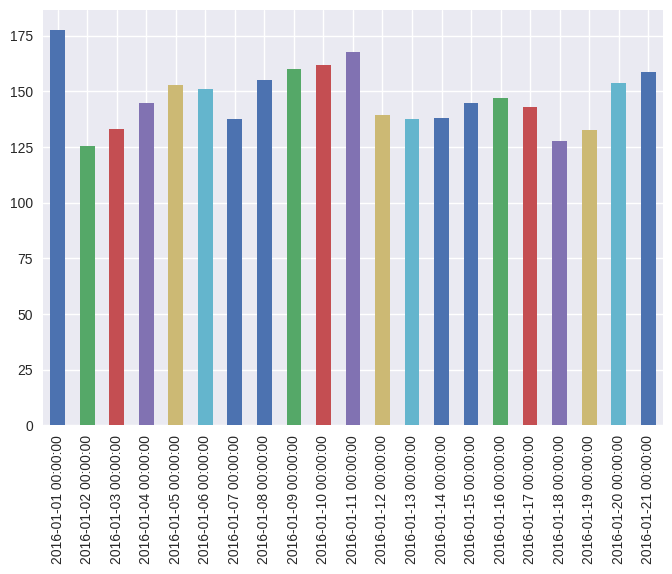

In [0]:
df.area_0.resample('D').mean().plot(kind='bar')

In [0]:
# df.area_0.plot()

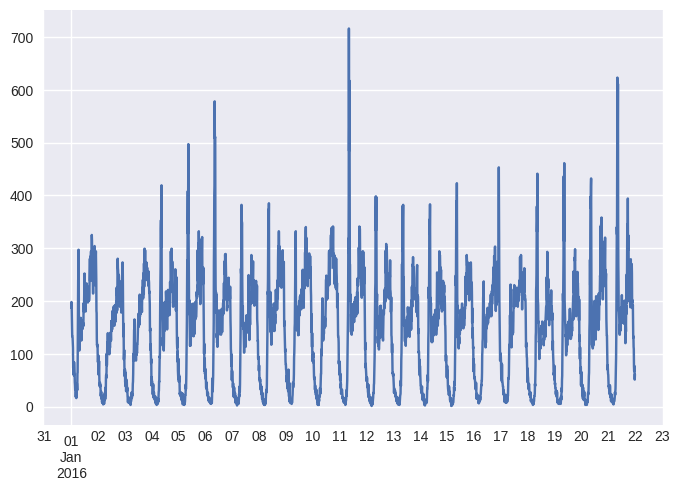

In [0]:
df.area_0.plot()

In [0]:
demand_hourly=df.asfreq('H', method='pad')
demand_hourly.head()

,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,...,area_56,area_57,area_58,area_59,area_60,area_61,area_62,area_63,area_64,area_65
2016-01-01 00:00:00,187.0,9.0,3.0,26.0,0.0,7.0,124.0,229.0,18.0,1.0,...,14.0,0.0,1.0,0.0,3.0,0.0,0.0,7.0,1.0,9.0
2016-01-01 01:00:00,133.0,8.0,0.0,25.0,2.0,7.0,349.0,205.0,22.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,6.0
2016-01-01 02:00:00,62.0,9.0,3.0,13.0,0.0,1.0,160.0,151.0,13.0,2.0,...,2.0,3.0,1.0,0.0,1.0,1.0,0.0,7.0,1.0,2.0
2016-01-01 03:00:00,61.0,1.0,1.0,8.0,0.0,2.0,201.0,129.0,6.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0
2016-01-01 04:00:00,18.0,0.0,0.0,2.0,0.0,0.0,145.0,67.0,18.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0


In [0]:
rng=pd.date_range(start="1/1/2016", periods=21, freq="B")
rng

DatetimeIndex(['2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-18',
               '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29'],
              dtype='datetime64[ns]', freq='B')

In [0]:
rng=pd.date_range(start="1/1/2016", periods=21, freq="C")
rng

DatetimeIndex(['2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-18',
               '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29'],
              dtype='datetime64[ns]', freq='C')

In [0]:
df.tail(5)

,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,...,area_56,area_57,area_58,area_59,area_60,area_61,area_62,area_63,area_64,area_65
2016-01-21 23:10:00,67.0,11.0,0.0,25.0,0.0,9.0,74.0,138.0,17.0,1.0,...,6.0,1.0,0.0,2.0,1.0,1.0,0.0,10.0,4.0,5.0
2016-01-21 23:20:00,77.0,13.0,1.0,26.0,0.0,3.0,89.0,110.0,22.0,0.0,...,3.0,2.0,3.0,0.0,2.0,1.0,0.0,4.0,1.0,4.0
2016-01-21 23:30:00,70.0,12.0,2.0,9.0,1.0,1.0,83.0,115.0,17.0,0.0,...,4.0,1.0,2.0,0.0,0.0,2.0,0.0,7.0,2.0,6.0
2016-01-21 23:40:00,51.0,11.0,1.0,13.0,1.0,3.0,86.0,95.0,15.0,0.0,...,9.0,4.0,3.0,0.0,0.0,0.0,0.0,2.0,3.0,7.0
2016-01-21 23:50:00,61.0,19.0,1.0,28.0,0.0,4.0,74.0,91.0,6.0,0.0,...,2.0,0.0,1.0,0.0,3.0,0.0,0.0,13.0,2.0,5.0


## 评价指标


In [0]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

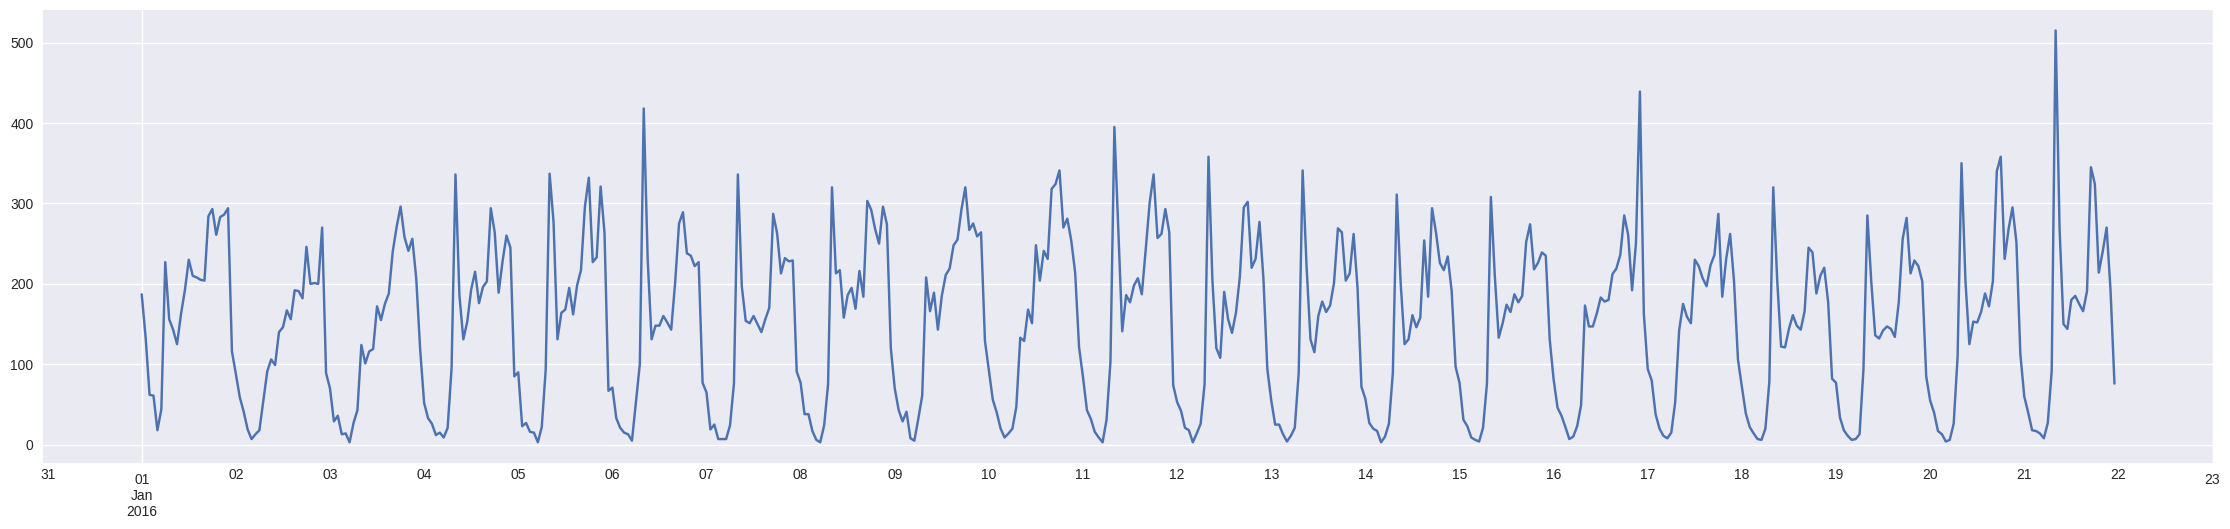

In [0]:
fig=plt.figure(figsize=(28,6))
demand_hourly.area_0.plot()

In [0]:
demand_hourly.columns

Index(['area_0', 'area_1', 'area_2', 'area_3', 'area_4', 'area_5', 'area_6',
       'area_7', 'area_8', 'area_9', 'area_10', 'area_11', 'area_12',
       'area_13', 'area_14', 'area_15', 'area_16', 'area_17', 'area_18',
       'area_19', 'area_20', 'area_21', 'area_22', 'area_23', 'area_24',
       'area_25', 'area_26', 'area_27', 'area_28', 'area_29', 'area_30',
       'area_31', 'area_32', 'area_33', 'area_34', 'area_35', 'area_36',
       'area_37', 'area_38', 'area_39', 'area_40', 'area_41', 'area_42',
       'area_43', 'area_44', 'area_45', 'area_46', 'area_47', 'area_48',
       'area_49', 'area_50', 'area_51', 'area_52', 'area_53', 'area_54',
       'area_55', 'area_56', 'area_57', 'area_58', 'area_59', 'area_60',
       'area_61', 'area_62', 'area_63', 'area_64', 'area_65'],
      dtype='object')

In [0]:
series_0=demand_hourly[["area_0"]]
# series_0.columns=['area_0']
series_0[-4:]

,area_0
2016-01-21 20:00:00,240.0
2016-01-21 21:00:00,270.0
2016-01-21 22:00:00,192.0
2016-01-21 23:00:00,76.0


In [0]:
series_1=demand_hourly[["area_1"]]

print(type(series_1))
# pd.Series(series_1.values)

type(series_1.squeeze())
# series_1.squeeze().tolist()
# series_1[-4:]
# series_1.columns

<class 'pandas.core.frame.DataFrame'>


pandas.core.series.Series

In [0]:
series_0[-4:].mean()

194.5

In [0]:
np.average(series_0[-4:])

194.5

In [0]:
def moving_avg(series, n):
  """
  Average of last n observation, eg. moving avg(series_hourly, 24), which can calculate the
  average value of last 24 hours observations
  
  - series: Pandas Series
  - n: integer
  """
  
  return series[-n:].mean()

moving_avg(series_0, 4)

194.5

### 滑动窗口平滑

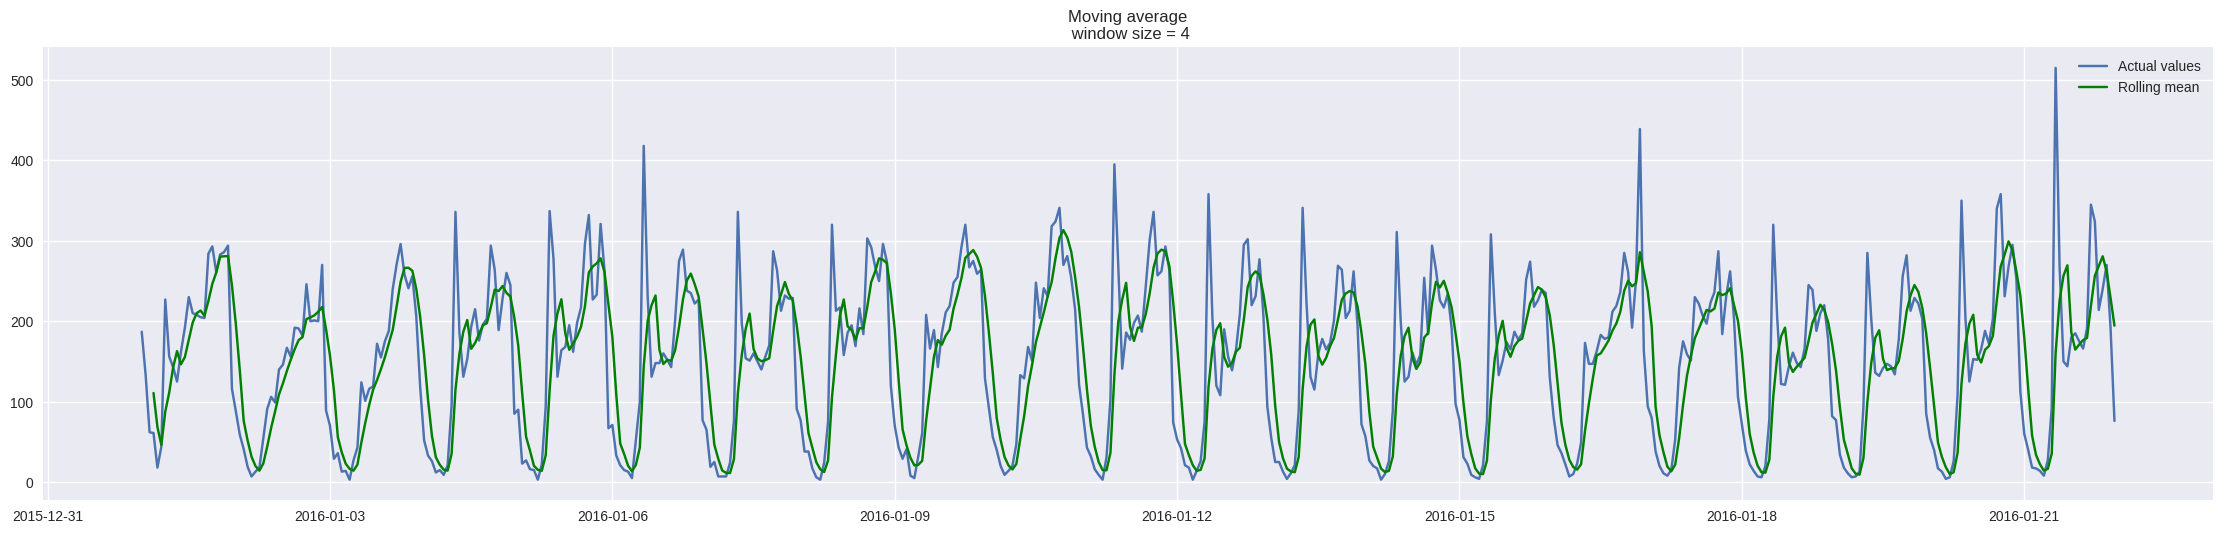

In [0]:
window_size=4
rolling_mean=series_0.rolling(window=window_size).mean()

FIGSIZE=(28, 6)
fig=plt.figure(figsize=FIGSIZE)
ax=fig.add_subplot(111)
ax.set_title("Moving average\n window size = {}".format(window_size))
ax.plot(series_0, label="Actual values")
ax.plot(rolling_mean, "g", label="Rolling mean")

plt.legend(loc='best')
plt.show()

#### 置信区间

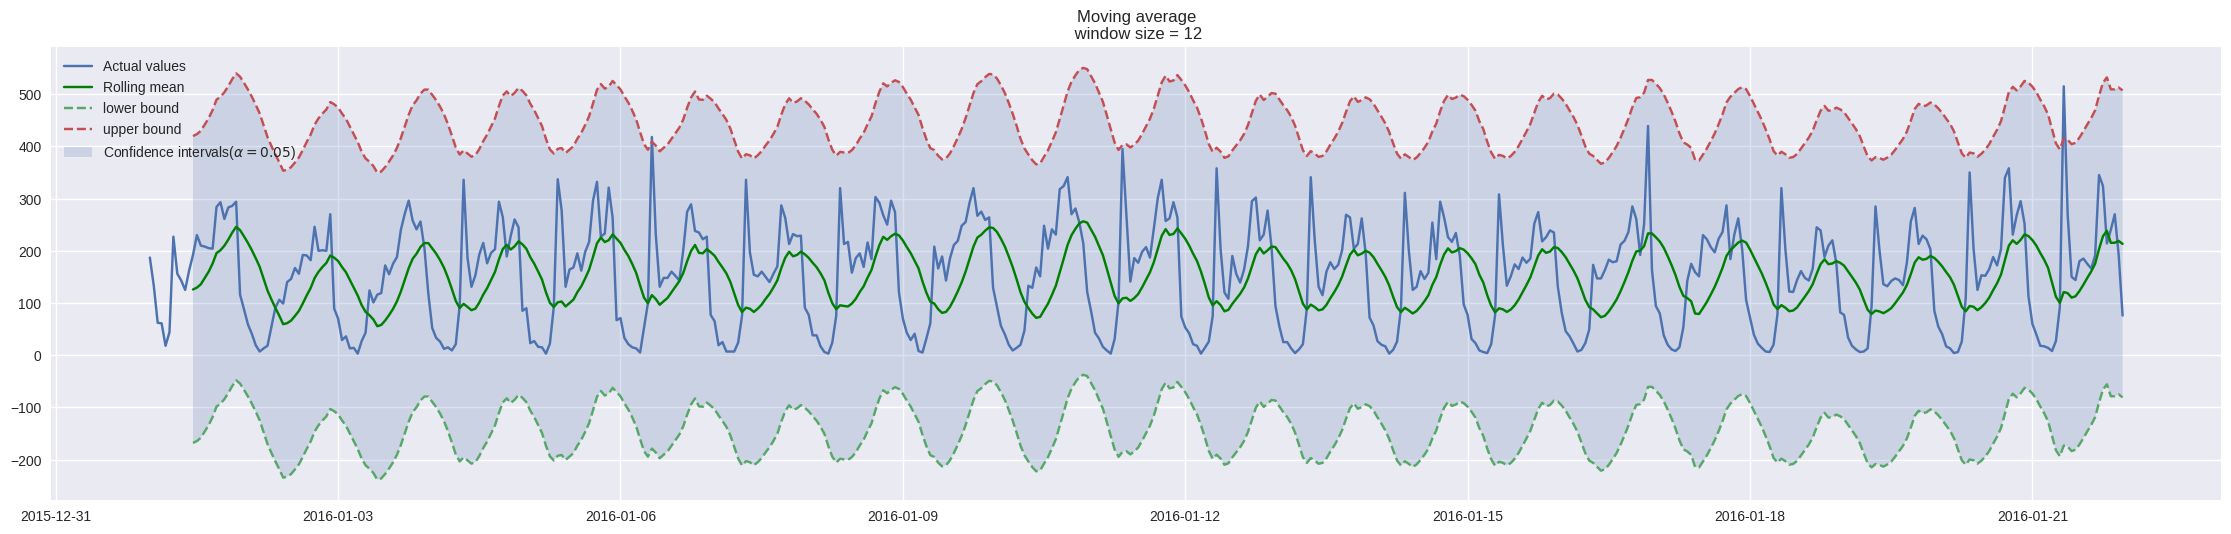

In [0]:
series=series_0

scale=1.96  # which means alpha=0.05, we have 95% confidence

window_size=12
rolling_mean=series.rolling(window=window_size).mean()

FIGSIZE=(28, 6)
fig=plt.figure(figsize=FIGSIZE)
ax=fig.add_subplot(111)
ax.set_title("Moving average\n window size = {}".format(window_size))
ax.plot(series, label="Actual values")
ax.plot(rolling_mean, "g", label="Rolling mean")


# plot confidence intervals
mae = mean_absolute_error(series[window_size:], rolling_mean[window_size:])
derivation=np.std(series[window_size:]-rolling_mean[window_size:])
lower_bound=rolling_mean-(mae+scale*derivation)

upper_bound=rolling_mean+(mae+scale*derivation)

ax.plot(lower_bound, '--', label='lower bound')
ax.plot(upper_bound, '--', label='upper bound')
ax.fill_between(lower_bound.index, lower_bound, upper_bound, alpha=0.2, label=r'Confidence intervals($\alpha=0.05$)')

plt.legend(loc='upper left')
plt.show()

In [0]:
# list(series_0.values)


#### 异常值检测

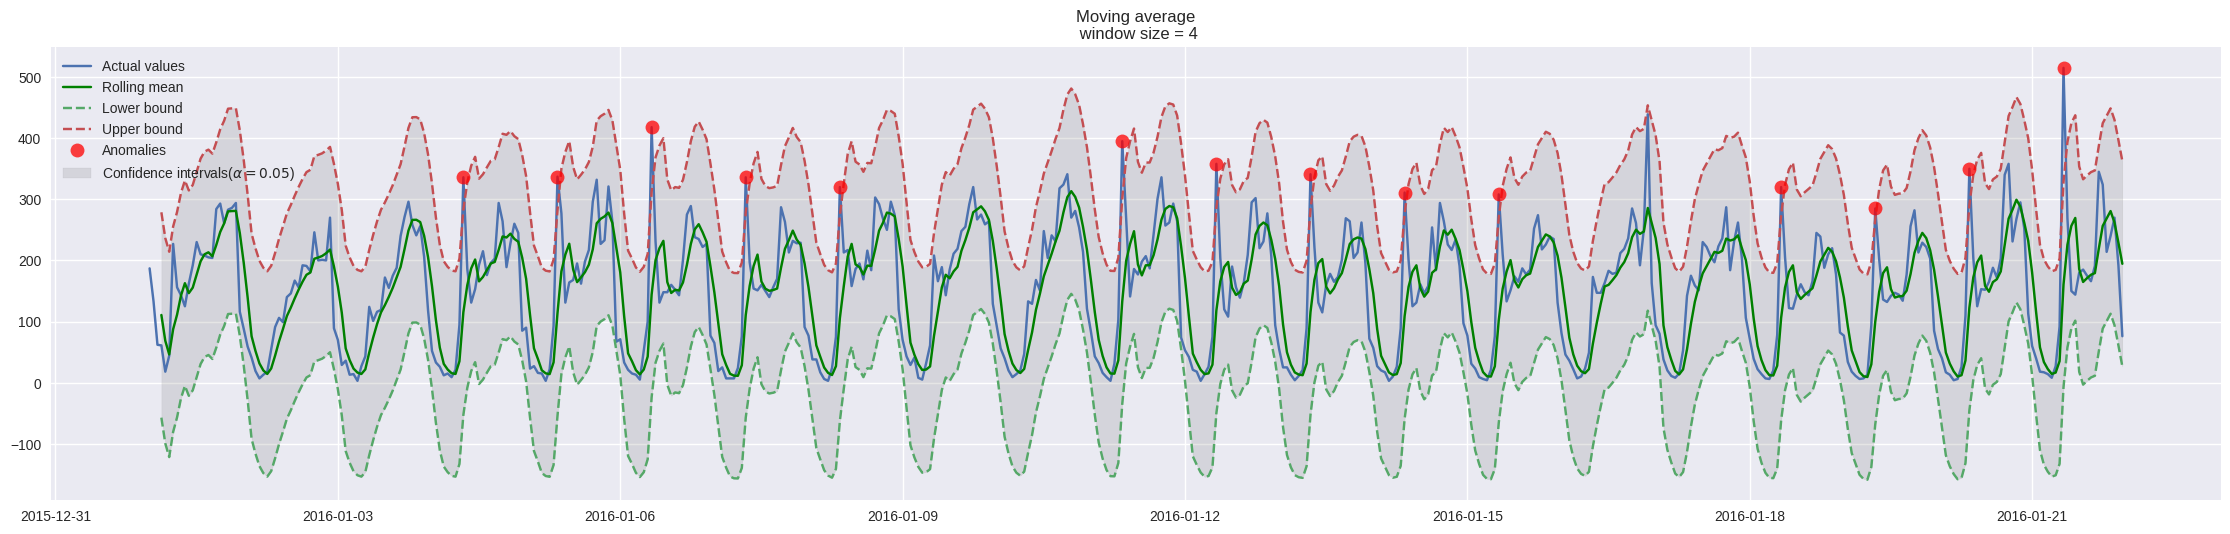

In [0]:
def plot_moving_avg(series, window_size, scale=1.96, FIGSIZE=(28, 6), plot_intervals=True, plot_anomalies=True):
  """
  - series: Pandas DataFrame, with just one column
  - window_size: integer
  - scale:80%	1.282
          85%	1.440
          90%	1.645
          95%	1.960
          99%	2.576
          99.5%	2.807
          99.9%	3.291
  - plot_intervals: boolean, True: to show the confidence intervals
  - plot_anomalies: boolean, True: to show the anomalies

  """
  
  rolling_mean=series.rolling(window=window_size).mean()
  
  fig=plt.figure(figsize=FIGSIZE)
  ax=fig.add_subplot(111)
  ax.set_title("Moving average\n window size = {}".format(window_size))
  ax.plot(series, label="Actual values")
  ax.plot(rolling_mean, "g", label="Rolling mean")


  # plot confidence intervals
  if plot_intervals:
    mae = mean_absolute_error(series[window_size:], rolling_mean[window_size:])
    derivation=np.std(series[window_size:]-rolling_mean[window_size:])
    lower_bound=rolling_mean-(mae+scale*derivation)

    upper_bound=rolling_mean+(mae+scale*derivation)

    ax.plot(lower_bound, '--', label='Lower bound')
    ax.plot(upper_bound, '--', label='Upper bound')
#     print('---------------------1')
#     print(upper_bound.values)
    
#     ax.fill_between(lower_bound.index, lower_bound.area_0, upper_bound.area_0, color='b',alpha=0.2, label=r'Confidence intervals($\alpha=0.05$)')  # error
    ax.fill_between(lower_bound.index, lower_bound.squeeze(), upper_bound.squeeze(), color='grey
                    ', alpha=0.2, label=r'Confidence intervals($\alpha=0.05$)')
    
    if plot_anomalies:
      anomalies=pd.DataFrame(index=series.index, columns=series.columns)
      anomalies[series<lower_bound]=series[series<lower_bound]
      anomalies[series>upper_bound]=series[series>upper_bound]
      ax.plot(anomalies, 'ro', markersize=10, label='Anomalies', alpha=0.75)

  plt.legend(loc='upper left')
  plt.grid('True')
  plt.show()

  
plot_moving_avg(series_0, 4)

从图中的异常点也能看出这些代表着工作日的早高峰。所以之后再分析的时候应当将节假日和工作日分开。

In [0]:
bussiness_rng=pd.date_range(start="1/1/2016", periods=21, freq="B")
bussiness_rng

DatetimeIndex(['2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-18',
               '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29'],
              dtype='datetime64[ns]', freq='B')

这里虽然筛选出了非周末的时间，但是1-1日在这里也是节假日，所以需要将其筛选出来。

In [0]:
from pandas.tseries.holiday import AbstractHolidayCalendar, nearest_workday, Holiday
from pandas.tseries.offsets import CustomBusinessDay
class myCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year day 1', month=1, day=1),#, observance=nearest_workday),
        Holiday('New Year day 2', month=1, day=2),
        Holiday('New Year day 2', month=1, day=3),
    ]
    
newyear_days = CustomBusinessDay(calendar=myCalendar())
pd.date_range('1/1/2017','1/21/2017',freq=newyear_days)

DatetimeIndex(['2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
               '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13',
               '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19',
               '2017-01-20'],
              dtype='datetime64[ns]', freq='C')

In [0]:
bussiness_rng=pd.bdate_range('1/4/2017','1/21/2017', freq='BH')  # workday
bussiness_rng

DatetimeIndex(['2017-01-04 09:00:00', '2017-01-04 10:00:00',
               '2017-01-04 11:00:00', '2017-01-04 12:00:00',
               '2017-01-04 13:00:00', '2017-01-04 14:00:00',
               '2017-01-04 15:00:00', '2017-01-04 16:00:00',
               '2017-01-05 09:00:00', '2017-01-05 10:00:00',
               ...
               '2017-01-19 15:00:00', '2017-01-19 16:00:00',
               '2017-01-20 09:00:00', '2017-01-20 10:00:00',
               '2017-01-20 11:00:00', '2017-01-20 12:00:00',
               '2017-01-20 13:00:00', '2017-01-20 14:00:00',
               '2017-01-20 15:00:00', '2017-01-20 16:00:00'],
              dtype='datetime64[ns]', length=104, freq='BH')

In [0]:
series_0.resample('BH')

DatetimeIndexResampler [freq=<BusinessHour: BH=09:00-17:00>, axis=0, closed=left, label=left, convention=start, base=0]

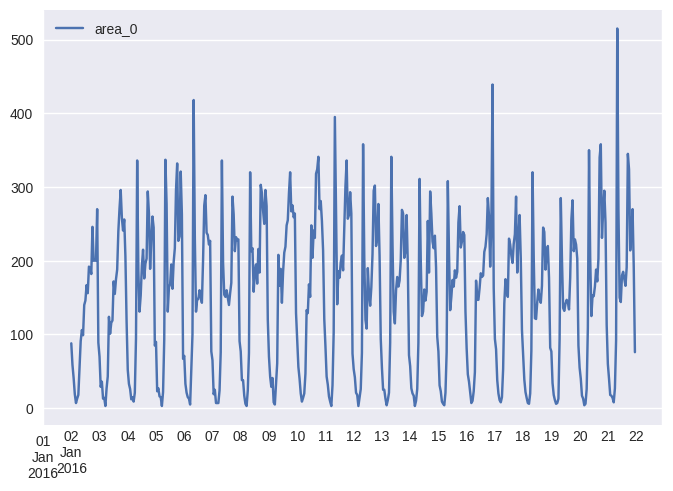

In [0]:
bussiness_hourly=series_0.resample(rule='1H', closed='left', label='left', base=17).sum() # workday hourly
workday_hourly=bussiness_hourly[24:]
workday_hourly.plot()

In [0]:
# series_0['2016-01-01':'2016-01-03']+series_0['2016-01-09']

In [0]:
series_0.resample('W-SAT').sum()

,area_0
2016-01-02,7360.0
2016-01-09,25616.0
2016-01-16,25630.0
2016-01-23,17683.0


##### Weekends+Holiday

Start
2016-01-01
2016-01-02
2016-01-03
2016-01-09
2016-01-10
2016-01-16
2016-01-17


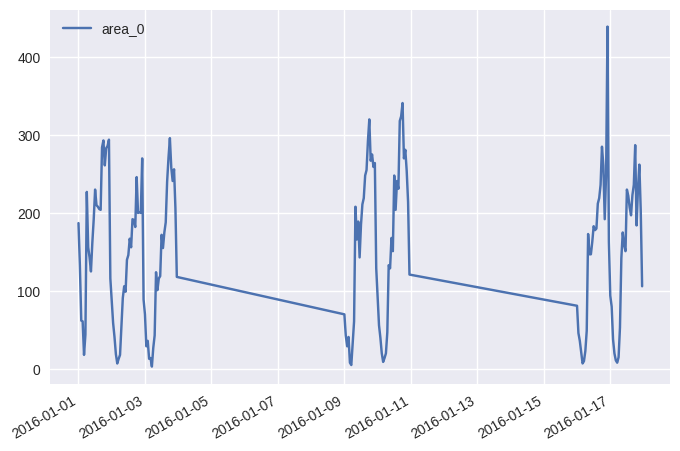

In [0]:
# holidays=['2016-01-01','2016-01-02', '2016-01-03','2016-01-09','2016-01-10','2016-01-16','2016-01-17','2016-01-23','2016-01-24']
print('Start')
holidays=['2016-01-01','2016-01-02', '2016-01-03','2016-01-09','2016-01-10','2016-01-16','2016-01-17']

holidays_hourly=pd.DataFrame()
for holiday in holidays:
  print(holiday)
  holidays_hourly=holidays_df.append(series_0[holiday])
# print(holidays_hourly)
holidays_hourly.plot()

In [0]:
# series_0['2016-01-01']
# plt.figure(figsize=(16, 3))
# plt.plot(holidays_hourly)
# plt.show()

##### Workdays

In [0]:
# series_0.resample('B') # based on bussiness day, day!

DatetimeIndexResampler [freq=<BusinessDay>, axis=0, closed=left, label=left, convention=start, base=0]

In [0]:
rng=pd.date_range(start="1/1/2016", periods=21, freq="B")
rng

DatetimeIndex(['2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-18',
               '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29'],
              dtype='datetime64[ns]', freq='B')

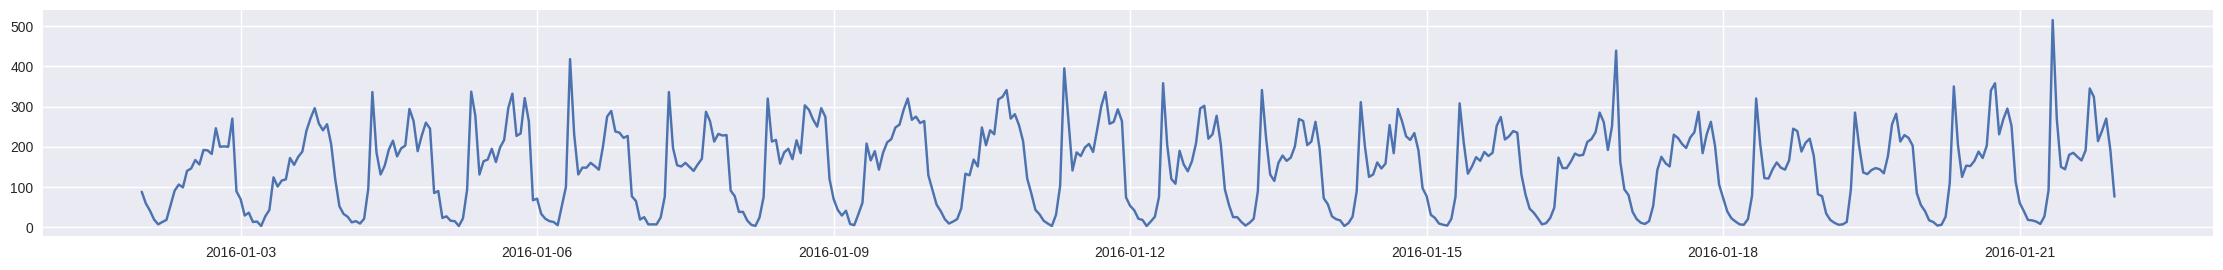

In [0]:
# series_0.resample('B').sum()
# series_0.resample('B').asfreq()[1:].plot()
plt.figure(figsize=(28, 3))
plt.plot(workday_hourly)
plt.show()

## 模型构建

In [0]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import warnings
import pandas.tseries
import itertools
import pandas.tseries  #The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead 
# from pandas.core import datetools 
import statsmodels.api as sm


#### Decompose

时间序列分解，将观察值分解成trend, seasonality和noise.

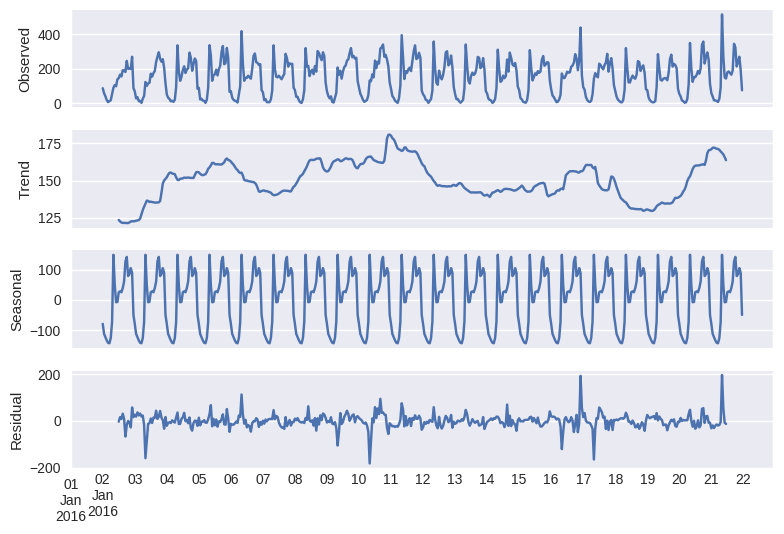

In [0]:
decomposition = sm.tsa.seasonal_decompose(workday_hourly, model='additive')
fig = decomposition.plot()
plt.show()

## ARIMA(Autoregressive Integrated Moving Average)

关键点三个参数p, d, q,这三个参数分别考虑了数据中的季节性，趋势和噪声。由于我们的数据都是冬季，所以不用考虑季节因素。

In [0]:
p = d = q = range(0, 2)

# Read：
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(len(pdq))

8


### Train/Test数据集划分

将